<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/simpleGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax.git

     |████████████████████████████████| 264 kB 26.8 MB/s 


Imports:

In [1]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()

Generate some noisy observations (aka 'training data'):

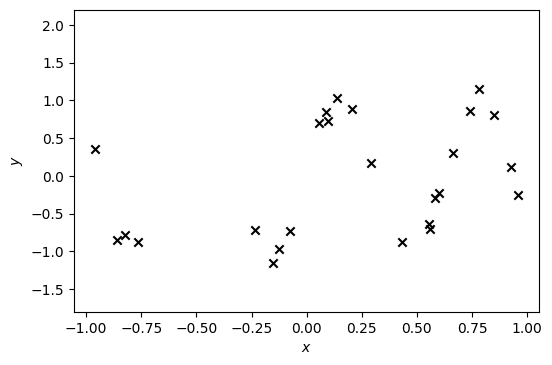

In [2]:
np.random.seed(0)

NUM_INIT_POINTS = 25 # number of observation points
NOISE_LEVEL = 0.1 # noise level

# Generate noisy data from a known function
f = lambda x: np.sin(10*x)

X = np.random.uniform(-1., 1., NUM_INIT_POINTS)
y = f(X) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS)

# Plot generated data
plt.figure(dpi=100)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(X, y, marker='x', c='k', zorder=1, label='Noisy observations')
plt.ylim(-1.8, 2.2);

In [3]:
# Get random number generator keys (see JAX documentation for why it is neccessary)
rng_key, rng_key_predict = gpax.utils.get_keys()

# initialize model
gp_model = gpax.ExactGP(1, kernel='RBF')
# run MCMC to obtain posterior samples
gp_model.fit(rng_key, X, y, num_chains=1)

sample: 100%|██████████| 4000/4000 [00:18<00:00, 217.20it/s, 7 steps of size 5.02e-01. acc. prob=0.91]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.17      0.03      0.17      0.12      0.22    983.38      1.00
    k_scale      1.24      0.86      0.99      0.31      2.31    769.97      1.00
      noise      0.03      0.02      0.03      0.01      0.06   1034.25      1.00



Now let's use our 'trained' model to obtain predictive posterior distribution on new/'test' data:

In [4]:
# prepare test inputs
X_test = np.linspace(-1, 1, 100)
# Get GP prediction
y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, n=200)

Plot results:

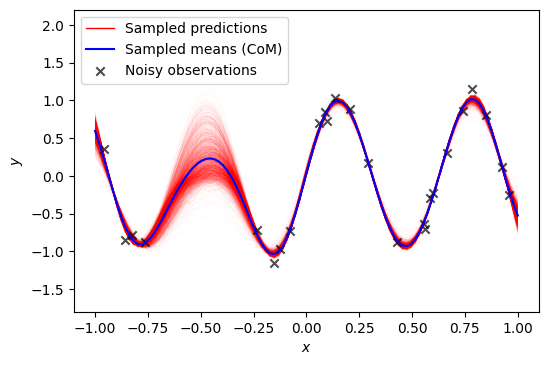

In [5]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in y_sampled:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, y_sampled[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, y_pred, lw=1.5, zorder=1, c='b', label='Sampled means (CoM)')
ax.legend(loc='upper left')
l.set_alpha(0)
ax.set_ylim(-1.8, 2.2);

It is also common in literature to draw the GP uncertainty (here defined as standard deviation across all sampled predictions) as a $2\sigma$ shaded region around the GP posterior mean:

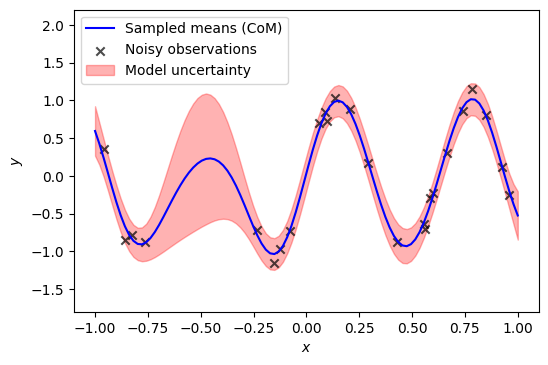

In [6]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=2, label="Noisy observations", alpha=0.7)
ax.plot(X_test, y_pred, lw=1.5, zorder=2, c='b', label='Sampled means (CoM)')
ax.fill_between(X_test, y_pred - y_sampled.std(axis=(0,1)), y_pred + y_sampled.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty")
ax.legend(loc='upper left')
ax.set_ylim(-1.8, 2.2);

Now let's do the same but with periodic kernel. The default priors on kernel hyperparameters, including a period, are $LogNormal(0,1)$. Let's use a $Uniform(0.1, 1.0)$ instead because we don't expect our period and lengthscale to be larger than half of the entire parameter range. The next cell demonstrates how to specify custom kernel priors using NumPyro's distributions:

In [7]:
import numpyro

def gp_kernel_prior():
    length = numpyro.sample("k_length", numpyro.distributions.Uniform(0, 1))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    period = numpyro.sample("period", numpyro.distributions.Uniform(0.1, 1.0))
    # the hyperparameters are returned as dictionary
    return {"k_length": length, "k_scale": scale, "period": period}

Infer the GP kernel hyperparameters using the priors specified above and make a prediction on 'test' inputs:

sample: 100%|██████████| 4000/4000 [00:11<00:00, 346.21it/s, 7 steps of size 5.44e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.89      0.09      0.91      0.77      1.00   2130.06      1.00
   k_scale      0.53      0.30      0.45      0.17      0.91   1360.11      1.00
     noise      0.02      0.01      0.02      0.01      0.04   1210.52      1.00
    period      0.63      0.01      0.62      0.62      0.63   1397.55      1.00



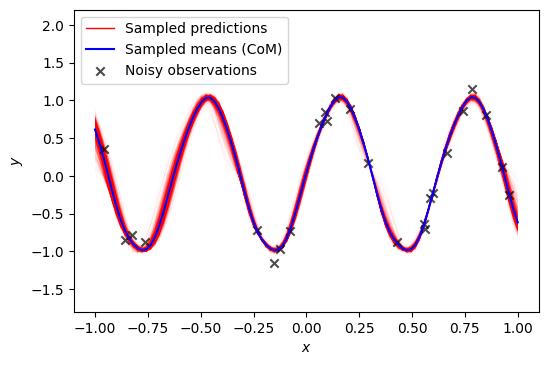

In [8]:
# Initialize model
gp_model = gpax.ExactGP(1, kernel='Periodic', kernel_prior=gp_kernel_prior)
# Run MCMC to obtain posterior samples
gp_model.fit(rng_key, X, y, num_chains=1)
# Get GP prediction
y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, n=200)

# Plot results
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in y_sampled:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, y_sampled[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, y_pred, lw=1.5, zorder=1, c='b', label='Sampled means (CoM)')
ax.legend(loc='upper left')
l.set_alpha(0)
ax.set_ylim(-1.8, 2.2);

Looks like we get a better prediction and our model is also more confident in it! Hence, one can use the GP kernel function to incorporate prior knowledge into the GP modeling.